In [1]:
# Nativos
import random as rn
import os
import sys
import gc

#calculo
import numpy as np
import pandas as pd
import scipy

import pandas as pd
import scorecardpy as sc

SEED = 29082013
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

### Utilitarios

In [2]:
def calcular_pesos(modelo):
    coef_model = pd.DataFrame(modelo.tvalues, columns=['t_value'])
    coef_model['t_value2'] = np.power(coef_model['t_value'],2)
    coef_model['total'] = sum(coef_model['t_value2'])
    coef_model['part'] = coef_model['t_value2'] / coef_model['total']
    coef_model['pesos'] = coef_model['part'] * 100
    return coef_model['pesos'].sort_values(ascending=True)

In [3]:
x_train = pd.read_csv("X_train.csv")
x_valid = pd.read_csv("X_valid.csv")

y_train = pd.read_csv("y_train.csv")
y_valid = pd.read_csv("y_valid.csv")

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((51120, 60), (12781, 60), (51120, 1), (12781, 1))

### >> Modleo mayor p-value

In [4]:
cols_aporte = [
 'Empleado',
 'Saldo_cuenta',
 'Valor_prestamo',
 'Autocontrol',
 'Impulsividad',
 'Confianza' 
]

In [5]:
x_train['target'] = y_train.values
matriz_corr = x_train[cols_aporte + ['target']].corr(method='pearson')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Saldo_cuenta,Valor_prestamo,Autocontrol,Impulsividad,Confianza,target
Empleado,1.00000,0.00228,-0.00777,0.00654,-0.00507,0.00307,-0.00068
Saldo_cuenta,0.00228,1.00000,-0.00130,-0.00113,0.00471,-0.00429,-0.00690
Valor_prestamo,-0.00777,-0.00130,1.00000,0.00992,-0.00262,0.00102,-0.00211
Autocontrol,0.00654,-0.00113,0.00992,1.00000,0.00412,0.00735,-0.00478
Impulsividad,-0.00507,0.00471,-0.00262,0.00412,1.00000,-0.00452,-0.00201
Confianza,0.00307,-0.00429,0.00102,0.00735,-0.00452,1.00000,0.00093
target,-0.00068,-0.00690,-0.00211,-0.00478,-0.00201,0.00093,1.00000


In [6]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00690
Autocontrol,0.00478
Valor_prestamo,0.00211
Impulsividad,0.00201
Confianza,0.00093
Empleado,0.00068


In [7]:
matriz_corr = x_train[cols_aporte + ['target']].corr(method='spearman')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Saldo_cuenta,Valor_prestamo,Autocontrol,Impulsividad,Confianza,target
Empleado,1.00000,0.00248,-0.00547,0.00558,-0.00528,0.00263,-0.00068
Saldo_cuenta,0.00248,1.00000,0.00325,-0.00083,0.00214,-0.00655,-0.00791
Valor_prestamo,-0.00547,0.00325,1.00000,0.00950,-0.00224,0.00085,-0.00436
Autocontrol,0.00558,-0.00083,0.00950,1.00000,0.00415,0.00759,-0.00407
Impulsividad,-0.00528,0.00214,-0.00224,0.00415,1.00000,-0.00383,-0.00219
Confianza,0.00263,-0.00655,0.00085,0.00759,-0.00383,1.00000,0.00042
target,-0.00068,-0.00791,-0.00436,-0.00407,-0.00219,0.00042,1.00000


In [8]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00791
Valor_prestamo,0.00436
Autocontrol,0.00407
Impulsividad,0.00219
Empleado,0.00068
Confianza,0.00042


In [9]:
if 'target' in x_train.columns:
    del x_train['target']

In [10]:
y_train.value_counts(normalize=True)

Incumplimiento
0                 0.858842
1                 0.141158
dtype: float64

In [11]:
len(x_train[cols_aporte].columns)

6

In [12]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

ros = RandomOverSampler(random_state=SEED)
X_resampled, y_resampled = ros.fit_resample(x_train[cols_aporte], y_train)

X_resampled.shape,  y_resampled.shape, type(X_resampled), type(y_resampled)

((87808, 6),
 (87808, 1),
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

kfold_off_on = StratifiedKFold(
    n_splits=3, 
    shuffle=True,
    random_state=SEED
)

param_grid_arbol = {
    'penalty': ['elasticnet', 'none'],
    'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],             
    'n_jobs': -1,
    'max_iter': [50, 100, 200, 500],
    'solver': ['liblinear', 'saga', 'sag'],
    'random_state': [SEED],
    'class_weight': ['balanced', None],
    'fit_intercept': [True, False],
    'C': [1, 10, 20]
}
model_arbol = LogisticRegression(random_state=SEED)

grid_arbol = RandomizedSearchCV(
    model_arbol, 
    {k: [v] if not isinstance(v, list) else v for k, v in param_grid_arbol.items()}, 
    cv=kfold_off_on, 
    n_jobs=4, 
    scoring='roc_auc', 
    verbose=2,
    n_iter=1000,
    refit=True
)

In [14]:
#help(grid_arbol.fit)

In [15]:
%%time
grid_arbol.fit(
    X_resampled,
    y_resampled,
)

best_params_arbol = grid_arbol.best_params_
score_arbol = grid_arbol.best_score_
result_2 = grid_arbol.best_estimator_

print("score: ", score_arbol)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.50119296 0.50119296        nan        nan
 0.50119277        nan 0.50106746 0.50118566 0.50119296        nan
 0.50141251 0.50141322        nan        nan 0.50142075        nan
        nan 0.50129119 0.50118668        nan 0.50117992        nan
 0.50118142        nan        nan 0.50140369        nan        nan
        nan        nan        nan        nan 0.50118668        nan
 0.50130449 0.50142142 0.5012383  0.50118668 0.50142075        nan
 0.50142143 0.50131089        nan 0.50142142        nan 0.50118668
        nan        nan 0.50142143 0.50119277 0.50142143        nan
        nan        nan        nan 0.50118668 0.50142076 0.50142143
 0.50118485 0.50142076 0.50119277 0.50142076        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.50118485        nan        n

score:  0.5014214320087809
Wall time: 16min 35s


In [16]:
best_params_arbol

{'solver': 'sag',
 'random_state': 29082013,
 'penalty': 'none',
 'n_jobs': -1,
 'max_iter': 100,
 'l1_ratio': 0.1,
 'fit_intercept': True,
 'class_weight': None,
 'C': 10}

In [17]:
import numpy as np
#prediciendo en base al modelo 
y_pred_prob_2_train = result_2.predict_proba(x_train[cols_aporte])[:,1]
y_pred_class_2_train = np.where(y_pred_prob_2_train < 0.5, 0 , 1)

y_pred_prob_2_valid = result_2.predict_proba(x_valid[cols_aporte])[:,1]
y_pred_class_2_valid = np.where(y_pred_prob_2_valid < 0.5, 0 , 1)

In [18]:
pd.Series(y_pred_class_2_train).value_counts()

0    25777
1    25343
dtype: int64

In [19]:
pd.Series(y_pred_class_2_valid).value_counts()

0    6500
1    6281
dtype: int64

<AxesSubplot:>

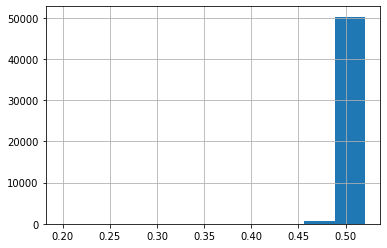

In [20]:
pd.Series(y_pred_prob_2_train).hist()

<AxesSubplot:>

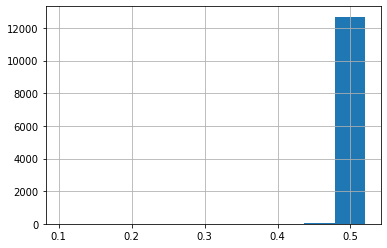

In [21]:
pd.Series(y_pred_prob_2_valid).hist()

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

print("/"*25, 'TRAIN')
auc = roc_auc_score(y_train, y_pred_prob_2_train)
print("AUC: %1.3f" % auc)
print("GINI: %1.3f" % (2*auc-1))

print("/"*25, 'VALIDATION')
auc_2 = roc_auc_score(y_valid, y_pred_prob_2_valid)
print("AUC: %1.3f" % auc_2)
print("GINI: %1.3f" % (2*auc_2-1))

///////////////////////// TRAIN
AUC: 0.505
GINI: 0.010
///////////////////////// VALIDATION
AUC: 0.495
GINI: -0.009


In [23]:
print("/"*25, 'TRAIN')
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_2_train))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_2_train))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_2_train))
print("accuracy_score   : %1.8f" % accuracy_score(y_train, y_pred_class_2_train))

print("/"*25, 'VALIDATION')
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_2_valid))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_2_valid))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_2_valid))
print("accuracy_score   : %1.8f" % accuracy_score(y_train, y_pred_class_2_train))

///////////////////////// TRAIN
RECALL     : 0.50457317
EFECTIVIDAD: 0.14366886
F1 SCORE   : 0.22365552
accuracy_score   : 0.50553599
///////////////////////// VALIDATION
RECALL     : 0.48170732
EFECTIVIDAD: 0.13835377
F1 SCORE   : 0.21496599
accuracy_score   : 0.50553599


#### >>> RECALL

In [24]:
from scipy.optimize import differential_evolution


optimization_rec = differential_evolution(
    lambda c: -1*recall_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_rec

     fun: -1.0
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 3
 success: True
       x: array([0.23889217])

In [25]:
corte_rec = optimization_rec['x'][0]
corte_rec

0.23889217415917813

In [26]:
y_pred_class_train_2_rec = np.where(y_pred_prob_2_train < corte_rec, 0 , 1)
y_pred_class_valid_2_rc = np.where(y_pred_prob_2_valid < corte_rec, 0 , 1)

In [27]:
pd.Series(y_pred_class_train_2_rec).value_counts()

1    51119
0        1
dtype: int64

In [28]:
pd.Series(y_pred_class_valid_2_rc).value_counts()

1    12779
0        2
dtype: int64

In [29]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_rec))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_rec))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_rec))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_rc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_rc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_rc))

///////////////////////// TRAIN
RECALL     : 1.00000000
EFECTIVIDAD: 0.14116082
F1 SCORE   : 0.24739865
///////////////////////// VALIDATION
RECALL     : 1.00000000
EFECTIVIDAD: 0.14116911
F1 SCORE   : 0.24741137


#### >>> EFECTIVIDAD

In [30]:
optimization_pre = differential_evolution(
    lambda c: -1*precision_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_pre

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision 

     fun: -0.5
 message: 'Optimization terminated successfully.'
    nfev: 197
     nit: 12
 success: True
       x: array([0.52005232])

In [31]:
corte_pre = optimization_pre['x'][0]

y_pred_class_train_2_pre = np.where(y_pred_prob_2_train < corte_pre, 0 , 1)
y_pred_class_valid_2_pre = np.where(y_pred_prob_2_valid < corte_pre, 0 , 1)

In [32]:
pd.Series(y_pred_class_train_2_pre).value_counts()

0    51118
1        2
dtype: int64

In [33]:
pd.Series(y_pred_class_valid_2_pre).value_counts()

0    12780
1        1
dtype: int64

#### >>> AUC

In [34]:
optimization_auc = differential_evolution(
    lambda c: -1*roc_auc_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_auc

     fun: -0.501008221727874
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 1
 success: True
       x: array([0.48979555])

In [35]:
corte_auc = optimization_auc['x'][0]
corte_auc

0.48979555486502585

In [36]:
y_pred_class_train_2_auc = np.where(y_pred_prob_2_train < corte_auc, 0 , 1)
y_pred_class_valid_2_auc = np.where(y_pred_prob_2_valid < corte_auc, 0 , 1)

In [37]:
pd.Series(y_pred_class_train_2_auc).value_counts()

1    49983
0     1137
dtype: int64

In [38]:
pd.Series(y_pred_class_valid_2_auc).value_counts()

1    12505
0      276
dtype: int64

In [39]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_auc))
print("accuracy_score   : %1.8f" % accuracy_score(y_train, y_pred_class_train_2_auc))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_auc))
print("accuracy_score   : %1.8f" % accuracy_score(y_valid, y_pred_class_valid_2_auc))

///////////////////////// TRAIN
RECALL     : 0.97949002
EFECTIVIDAD: 0.14140808
F1 SCORE   : 0.24713719
accuracy_score   : 0.15760955
///////////////////////// VALIDATION
RECALL     : 0.97616408
EFECTIVIDAD: 0.14082367
accuracy_score   : 0.15601283
